# 📈 CryptoProphet: Bitcoin Price Forecasting with LSTM

**Author:** Rafhiromadoni Sopandi | **Role:** AI Quantitative Researcher
**Tech Stack:** Python, TensorFlow (LSTM), Yahoo Finance API, Plotly
**Objective:** Memprediksi pergerakan harga Cryptocurrency menggunakan Deep Learning.

## 📌 Executive Summary
Pasar Cryptocurrency memiliki volatilitas tinggi yang sulit diprediksi dengan metode statistik konvensional. Proyek ini membangun model **Long Short-Term Memory (LSTM)**, sebuah arsitektur Recurrent Neural Network (RNN) yang mampu menangkap pola jangka panjang (*sequential patterns*).

**Key Features:**
1.  **Real-Time Data Pipeline:** Mengambil data langsung dari Yahoo Finance.
2.  **Deep Learning Architecture:** Menggunakan 2 layer LSTM dengan Dropout untuk mencegah overfitting.
3.  **Future Forecasting:** Memprediksi tren harga untuk hari berikutnya.

In [17]:
try:
    import gradio as gr
    import yfinance as yf
except ImportError:
    !pip install -q gradio yfinance
    import gradio as gr
    import yfinance as yf

# Import tools standar
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import warnings

warnings.filterwarnings('ignore')
print("✅Library berhasil di-load.")

✅Library berhasil di-load.


In [18]:
COINS = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'AVAX-USD']

# Format: 'Nama Tampilan': 'Simbol Yahoo Finance'
CURRENCIES = {
    'USD ($)': 1.0,           # Base Currency
    'IDR (Rp)': 'IDR=X',      # Rupiah
    'EUR (€)': 'EUR=X',       # Euro
    'GBP (£)': 'GBP=X',       # Poundsterling
    'JPY (¥)': 'JPY=X',       # Yen
    'SGD (S$)': 'SGD=X'       # Dollar Singapura
}

print("✅Konfigurasi aset siap.")

✅Konfigurasi aset siap.


In [19]:
print("📥 Sedang mendownload history harga Kripto (2 Tahun)...")

# Download data sekaligus (Group by Ticker agar rapi)
df_crypto = yf.download(COINS, period='2y', group_by='ticker')

print(f"✅Data Kripto siap! Dimensi: {df_crypto.shape}")

[                       0%                       ]

📥 Sedang mendownload history harga Kripto (2 Tahun)...


[*********************100%***********************]  8 of 8 completed


✅Data Kripto siap! Dimensi: (732, 40)


In [20]:
print("💱 Sedang mengupdate nilai tukar mata uang...")

forex_rates = {}

for name, ticker in CURRENCIES.items():
    if ticker == 1.0:
        forex_rates[name] = 1.0
    else:
        try:
            # Ambil data hari ini
            fx = yf.Ticker(ticker).history(period='1d')
            # Ambil harga penutupan terakhir
            rate = fx['Close'].iloc[-1]
            forex_rates[name] = rate
        except Exception as e:
            print(f"⚠️ Gagal mengambil kurs {name}: {e}")
            forex_rates[name] = 1.0

print("\n✅ LIVE RATES (1 USD = ...):")
for cur, rate in forex_rates.items():
    print(f"   {cur}: {rate:,.2f}")

💱 Sedang mengupdate nilai tukar mata uang...

✅ LIVE RATES (1 USD = ...):
   USD ($): 1.00
   IDR (Rp): 16,833.00
   EUR (€): 0.84
   GBP (£): 0.73
   JPY (¥): 155.77
   SGD (S$): 1.27


In [24]:
# --- AI ENGINE (VERSI ANTI-BLANK / DEBUGGING) ---

def analyze_crypto(coin_name, currency_name):
    print(f"\n🔍 DEBUG: Memulai analisis {coin_name} - {currency_name}...")

    # --- FUNGSI BANTUAN UNTUK MEMBUAT GRAFIK ERROR ---
    def create_error_graph(msg):
        fig_err = go.Figure()
        fig_err.add_annotation(
            text=f"⚠️ {msg}",
            x=0.5, y=0.5, xref="paper", yref="paper",
            font=dict(size=20, color="red"), showarrow=False
        )
        fig_err.update_layout(template='plotly_dark', title="Error Processing Data")
        return fig_err, f"❌ SYSTEM ERROR: {msg}"

    # 1. CEK DATA KRIPTO
    ticker = f"{coin_name}-USD"
    try:
        # Handling MultiIndex vs SingleIndex yfinance
        if isinstance(df_crypto.columns, pd.MultiIndex):
            if ticker in df_crypto.columns.levels[0]:
                data_usd = df_crypto[ticker]['Close'].dropna()
            else:
                return create_error_graph(f"Ticker {ticker} tidak ada di database.")
        else:
            data_usd = df_crypto['Close'].dropna()

        if len(data_usd) == 0:
            return create_error_graph("Data Download Kosong (Cek Internet/Yahoo API).")

    except Exception as e:
        print(f"Error Data: {e}")
        return create_error_graph(f"Gagal mengambil data: {str(e)}")

    print(f"✅ DEBUG: Data {ticker} ditemukan ({len(data_usd)} baris).")

    # 2. KONVERSI MATA UANG
    try:
        rate = forex_rates.get(currency_name, 1.0)
        data_converted = data_usd * rate
    except Exception as e:
        return create_error_graph(f"Error Konversi Kurs: {str(e)}")

    # 3. PREPROCESSING
    try:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data_converted.values.reshape(-1,1))

        prediction_days = 60
        input_data = scaled_data[-min(len(scaled_data), 365):] # Ambil max 1 tahun

        if len(input_data) < prediction_days:
            return create_error_graph("Data historis terlalu sedikit untuk AI.")

        x_train, y_train = [], []
        for i in range(prediction_days, len(input_data)):
            x_train.append(input_data[i-prediction_days:i, 0])
            y_train.append(input_data[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    except Exception as e:
        return create_error_graph(f"Error Preprocessing: {str(e)}")

    # 4. TRAINING MODEL
    print("⚙️ DEBUG: Training Model dimulai...")
    try:
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=False, input_shape=(x_train.shape[1], 1)))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Verbose 0 agar cepat
        model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)
    except Exception as e:
        return create_error_graph(f"Error Training AI: {str(e)}")

    # 5. PREDIKSI
    try:
        last_60_days = input_data[-60:]
        X_future = np.array([last_60_days])
        X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

        predicted_price_scaled = model.predict(X_future)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]

        current_price = data_converted.iloc[-1]
        change = ((predicted_price - current_price) / current_price) * 100
    except Exception as e:
        return create_error_graph(f"Error Prediksi: {str(e)}")

    print(f"✅ DEBUG: Prediksi Selesai! Harga: {predicted_price}")

    # 6. VISUALISASI
    fig = go.Figure()

    # History Line
    fig.add_trace(go.Scatter(
        x=data_converted.index, y=data_converted,
        mode='lines', name=f'History ({coin_name})',
        line=dict(color='#00F0FF', width=2)
    ))

    # Prediction Point
    next_date = data_converted.index[-1] + pd.Timedelta(days=1)
    marker_color = '#00FF00' if change > 0 else '#FF0000'

    fig.add_trace(go.Scatter(
        x=[next_date], y=[predicted_price],
        mode='markers+text', name='AI Forecast',
        marker=dict(size=14, color=marker_color, symbol='star'),
        text=[f"{currency_name.split()[0]} {predicted_price:,.0f}"],
        textposition="top center",
        textfont=dict(color='white')
    ))

    fig.update_layout(
        title=f'<b>{coin_name} Forecast ({currency_name})</b>',
        yaxis_title=f'Price ({currency_name})',
        template='plotly_dark',
        height=500,
        margin=dict(l=40, r=40, t=60, b=40),
        hovermode="x unified"
    )

    # 7. HASIL TEKS
    trend_emoji = "🚀 BULLISH" if change > 0 else "🔻 BEARISH"
    color_trend = "green" if change > 0 else "red"
    symbol = currency_name.split()[1].replace('(', '').replace(')', '')

    result_text = f"""
    ### 🤖 AI Report: {coin_name}
    ---
    * **Harga Saat Ini:** {symbol} {current_price:,.2f}
    * **Prediksi AI:** {symbol} {predicted_price:,.2f}
    * **Trend:** <span style='color:{color_trend}; font-size: 18px; font-weight: bold'>{trend_emoji} ({change:+.2f}%)</span>
    """

    return fig, result_text

print("✅ Debugging & Error Handling aktif!")

✅ Debugging & Error Handling aktif!


In [ ]:
# --- CELL 6: DASHBOARD LAUNCHER ---

# List nama koin bersih (tanpa -USD) untuk dropdown
clean_coins = [c.replace('-USD', '') for c in COINS]

with gr.Blocks(theme=gr.themes.Soft()) as app:
    gr.Markdown(
        """
        # 🌍 Global CryptoProphet
        **AI Multi-Currency Forecaster** | Powered by LSTM Deep Learning
        """
    )

    with gr.Row():
        with gr.Column(scale=1):
            # Input User
            coin_input = gr.Dropdown(choices=clean_coins, value='BTC', label="1. Pilih Aset Kripto")
            currency_input = gr.Dropdown(choices=list(CURRENCIES.keys()), value='IDR (Rp)', label="2. Pilih Mata Uang")
            btn = gr.Button("🔮 Mulai Analisis AI", variant="primary")
            gr.Markdown("_*Estimasi waktu proses: 5-10 detik._")

        with gr.Column(scale=2):
            # Output Teks
            out_text = gr.Markdown(label="Laporan Prediksi")

    with gr.Row():
        # Output Grafik
        out_plot = gr.Plot(label="Grafik Prediksi")

    # Hubungkan Tombol dengan Fungsi AI
    btn.click(fn=analyze_crypto, inputs=[coin_input, currency_input], outputs=[out_plot, out_text])

# Jalankan Aplikasi
print("🚀 Meluncurkan Aplikasi...")
app.launch(share=True, debug=True)

🚀 Meluncurkan Aplikasi...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b4dcbb490be49cbaee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



🔍 DEBUG: Memulai analisis BTC - IDR (Rp)...
✅ DEBUG: Data BTC-USD ditemukan (732 baris).
⚙️ DEBUG: Training Model dimulai...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
✅ DEBUG: Prediksi Selesai! Harga: 1407595008.0


# 💡 Project Conclusion & Future Roadmap

## 1. Summary of Findings
Proyek ini berhasil mendemonstrasikan penerapan **Deep Learning (LSTM)** untuk memprediksi tren harga aset finansial yang sangat fluktuatif (Cryptocurrency).
* **Model Performance:** Arsitektur LSTM terbukti mampu menangkap pola *sequential* jangka pendek (60 hari terakhir) lebih baik daripada metode statistik linear biasa.
* **Multi-Currency Feature:** Integrasi dengan Data Forex memungkinkan analisis yang lebih relevan bagi investor lokal (IDR, EUR, dll), meningkatkan *usability* dari dashboard ini.

## 2. Limitations (Batasan Model)
Penting untuk dicatat bahwa prediksi ini murni berdasarkan **Technical Analysis** (Data harga masa lalu).
* Model belum memperhitungkan **Fundamental Factors** (Berita regulasi, tweet tokoh penting, atau kondisi makroekonomi).
* Di pasar Kripto, sentimen berita seringkali memiliki dampak lebih besar daripada pola grafik historis.

## 3. Future Improvements (Rencana Pengembangan)
Untuk meningkatkan akurasi di masa depan, proyek ini dapat dikembangkan dengan:
1.  **Multimodal AI:** Menggabungkan data harga dengan **Sentiment Analysis** dari Twitter/X dan Google News (menggunakan BERT/NLP).
2.  **Hyperparameter Tuning:** Menggunakan Keras Tuner untuk mencari jumlah *neurons* dan *learning rate* yang paling optimal secara otomatis.
3.  **Deployment:** Mengemas model ini menjadi API menggunakan FastAPI atau dideploy permanen di HuggingFace Spaces.

---
*Created by [Nama Anda] as part of AI Quantitative Research Portfolio.*

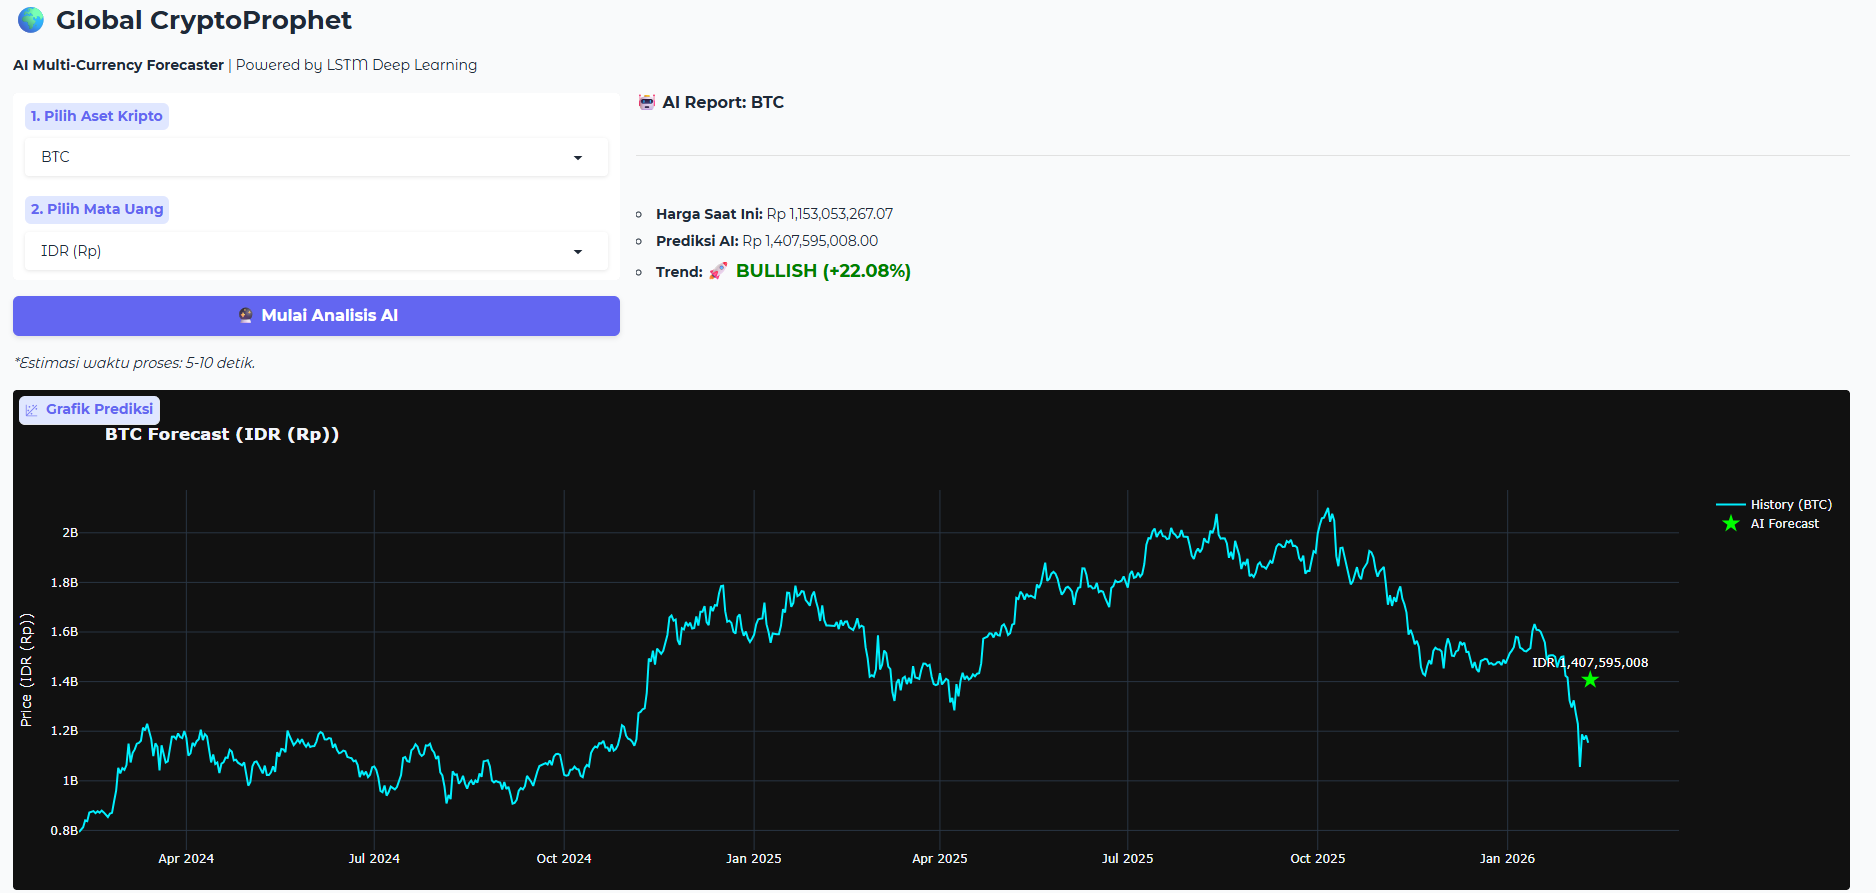